# Challenges and Questions: final project phase
___

In [1]:
import sys
import os

milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess
from bert_models import BERTModel

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initially, we'll identify which model performs best for our task (assumption: `HateBERT`). To do this, we'll start with the base scenario: a balanced or unbalanced dataset with the initial labels. 

Once we determine the best model, we'll retrain it using various scenarios, including both balanced and unbalanced datasets, along with 3 distinct types of label aggregation: `original` (provided by the dataset creators), `majority voting` (applied to the labels from 3 annotators) and `at least one sexist` (where a label is "sexist" if at least 1 annotator assigned it as such). These combinations of dataset type and aggregation method yield 6 distinct configurations for model training.

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

# different aggregation methods
y_train_mv, y_train_balanced_mv, y_val_mv, y_test_mv = import_preprocess.apply_aggregation(aggregation_type='majority voting')
y_train_alos, y_train_balanced_alos, y_val_alos, y_test_alos = import_preprocess.apply_aggregation(aggregation_type='at least one sexist')

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


# BERT-based models

- PyTorch fine-tuning

Loading pretrained model and tokenizer: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Pretrained weights loaded successfully.
Training started.
Epoch 1/10, Cross-entropy Loss: 0.8049
Validation Loss: 0.7129, Validation Accuracy: 0.5000
Epoch 2/10, Cross-entropy Loss: 0.6375
Validation Loss: 0.7006, Validation Accuracy: 0.6000
Epoch 3/10, Cross-entropy Loss: 0.5200
Validation Loss: 0.7209, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 0.4352
Validation Loss: 0.7627, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 0.3700
Validation Loss: 0.8137, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


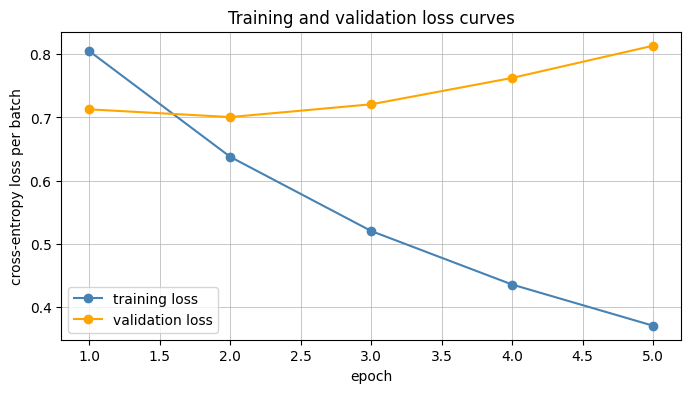

In [3]:
model = BERTModel("HateBERT")
model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3, plot_training_curve=True)

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



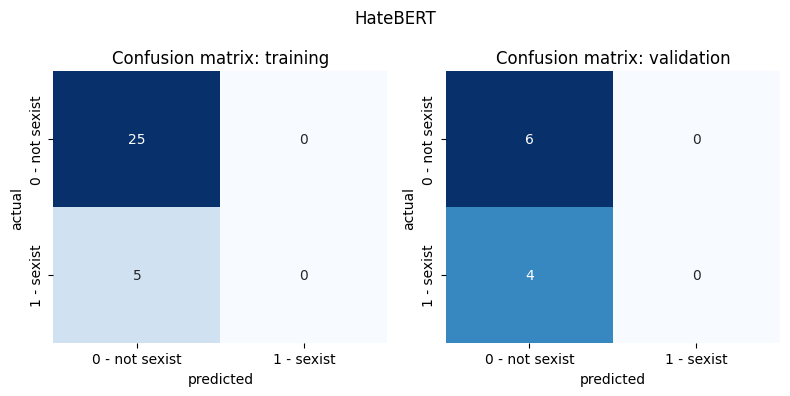

In [4]:
res = model.evaluate({"training": X_train[:30], "validation": X_val[:10]}, [y_train[:30], y_val[:10]], model_name=model.model_name)

- Hugging Face Trainer API -> extremely slow :( 

In [3]:
model = BERTModel("HateBERT")
model.train_hugging_face_api(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

Loading pretrained model and tokenizer: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.


Map: 100%|██████████| 10/10 [00:00<00:00, 732.32 examples/s]
d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
d:\Natural Language Processing\Project new\NLP_24W_VSHJ\challenges\bert_models.py:264: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training using Hugging Face Trainer API...


                                               
 10%|█         | 1/10 [01:51<15:48, 105.42s/it]

{'eval_loss': 0.6864382028579712, 'eval_accuracy': 0.6, 'eval_runtime': 6.0714, 'eval_samples_per_second': 1.647, 'eval_steps_per_second': 0.165, 'epoch': 1.0}


                                               
 20%|██        | 2/10 [03:51<15:12, 114.02s/it]

{'eval_loss': 0.7071596384048462, 'eval_accuracy': 0.6, 'eval_runtime': 6.1607, 'eval_samples_per_second': 1.623, 'eval_steps_per_second': 0.162, 'epoch': 2.0}


                                               
 30%|███       | 3/10 [06:36<15:47, 135.39s/it]

{'eval_loss': 0.738185465335846, 'eval_accuracy': 0.6, 'eval_runtime': 9.6218, 'eval_samples_per_second': 1.039, 'eval_steps_per_second': 0.104, 'epoch': 3.0}


                                               
 40%|████      | 4/10 [08:56<13:41, 136.86s/it]

{'eval_loss': 0.7716742753982544, 'eval_accuracy': 0.6, 'eval_runtime': 11.2262, 'eval_samples_per_second': 0.891, 'eval_steps_per_second': 0.089, 'epoch': 4.0}


 40%|████      | 4/10 [09:01<13:32, 135.35s/it]

{'train_runtime': 541.2087, 'train_samples_per_second': 0.554, 'train_steps_per_second': 0.018, 'train_loss': 0.5210871696472168, 'epoch': 4.0}



100%|██████████| 1/1 [00:00<00:00, 26.90it/s]

Evaluation Results: {'eval_loss': 0.6864382028579712, 'eval_accuracy': 0.6, 'eval_runtime': 11.9877, 'eval_samples_per_second': 0.834, 'eval_steps_per_second': 0.083, 'epoch': 4.0}


In [3]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### **1. RoBERTa**

https://arxiv.org/abs/1907.11692 (paper)

Key features of the original RoBERTa:
- improvement over BERT
- pre-trained in a self-supervised manner: raw texts only, with no humans labelling 
- dynamic masking: 
    - BERT uses static masking during pretraining (the same tokens are masked across all training epochs)
    - RoBERTa uses dynamic masking, where tokens are randomly masked in each epoch
- next sentence prediction loss (NSP):
    - BERT: includes NSP as part of its pretraining objective, where the model learns to predict whether one sentence logically follows another
    - RoBERTa: removes NSP because experiments showed that removing it leads to better results
- pre-training objective:
    - BERT: masked language modeling (MLM) objective along with the NSP task
    - RoBERTa: only the MLM objective 
- larger training data and batch size:
    - BERT: pretrained on 16GB of data (BooksCorpus and English Wikipedia); small batch size; 1 million training steps (pass of a batch)
    - RoBERTa: 10 times more data; larger batch size; 500,000 training steps

HF model we're using: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
- trained on ~124M tweets from January 2018 to December 2021 and finetuned for sentiment analysis with the TweetEval benchmark
- labels of the pre-trained model: 0 - negative; 1 - neutral; 2 - positive; by setting `ignore_mismatched_sizes=True` while loading the pre-trained model, the weights of the output layer won't be loaded, instead, they will be randomly initialized


Loading pretrained model and tokenizer: RoBERTa...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Pretrained weights loaded successfully.
Training started.
Epoch 1/10, Cross-entropy Loss: 0.8022
Validation Loss: 0.7142, Validation Accuracy: 0.6000
Epoch 2/10, Cross-entropy Loss: 0.4981
Validation Loss: 0.9022, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 0.4345
Validation Loss: 0.9821, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 0.4167
Validation Loss: 0.8694, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


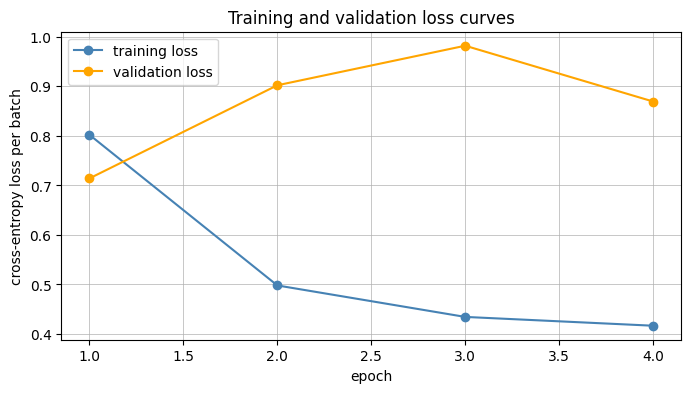

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



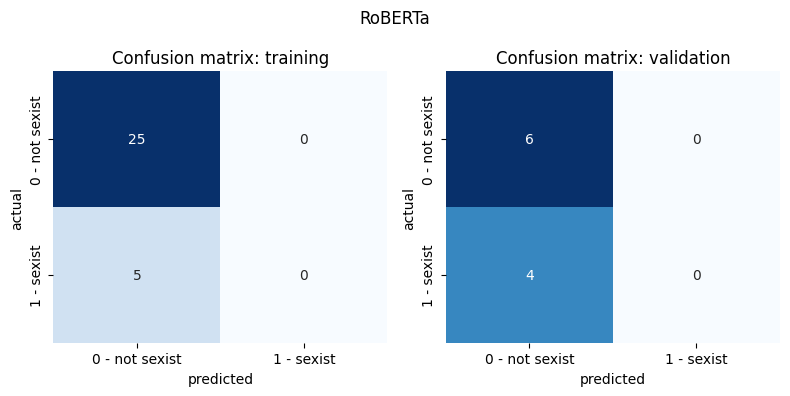

In [4]:
roberta_model = BERTModel("RoBERTa")
roberta_model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

res = roberta_model.evaluate({"training": X_train[:30], "validation": X_val[:10]}, [y_train[:30], y_val[:10]], model_name=roberta_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

#### **2. DeBERTa**

https://arxiv.org/abs/2006.03654 (paper)

Key features of the original DeBERTa:
- improvement over BERT and RoBERTa
- handling content and position information:
    - BERT: adds positional encoding to the embedding vectors to incorporate position information
    - DeBERTa: uses disentangled attention mechanism - each word represented with 2 separate vectors (1 encoding content and the other encoding position); attention weights are computed using disentangled matrices that separately handle content and positional information
- decoder part: 
    - BERT: uses the standard transformer encoder and positional encodings during the input processing, without a separate decoder mechanism
    - DeBERTa: uses enhanced mask decoder - the decoding layer incorporates absolute positions, allowing the model to better capture positional relationships and improve its ability to predict masked tokens.
- virtual adversarial training (VAT) method is used during fine-tuning to enhance generalization (making the model less sensitive to slight input changes and improving performance on downstream tasks)
- training data:
    - RoBERTa: ~160GB data
    - DeBERTa: trained on half of the training data used for RoBERTa-Large, but outperforms it across multiple NLP tasks

HF model we're using: https://huggingface.co/microsoft/deberta-v3-base

- base DeBERTa model fine-tuned with MNLI task (multi-genre natural language inference): determine the relationship between 2 sentences (3 categories: 1. entailment: 2nd sentence logically follows from the 1st, 2. contradiction: 2nd contradicts the 1st, 3. neutral)
- it might be better if we manage to find some model that was fine-tuned on the social media data or fine-tuned on some task more similar to our

Loading pretrained model and tokenizer: DeBERTa...


You are using a model of type deberta-v2 to instantiate a model of type deberta. This is not supported for all configurations of models and can yield errors.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'deberta.encoder.layer.0.attention.self.in_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.0.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.0.attention.self.q_bias', 'deberta.encoder.layer.0.attention.self.v_bias', 'deberta.encoder.layer.1.attention.self.in_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.1.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.1.attention.self.q_bias', 'deberta.encoder.layer.1.attention.s

Pretrained weights loaded successfully.
Training started.


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Cross-entropy Loss: 0.6877
Validation Loss: 0.6739, Validation Accuracy: 0.6000
Epoch 2/10, Cross-entropy Loss: 0.6298
Validation Loss: 0.6609, Validation Accuracy: 0.6000
Epoch 3/10, Cross-entropy Loss: 0.5183
Validation Loss: 0.7576, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 0.4567
Validation Loss: 0.8640, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 0.4405
Validation Loss: 0.9288, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


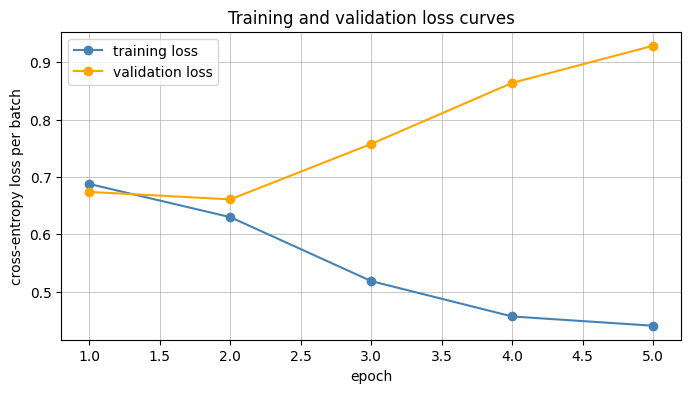

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



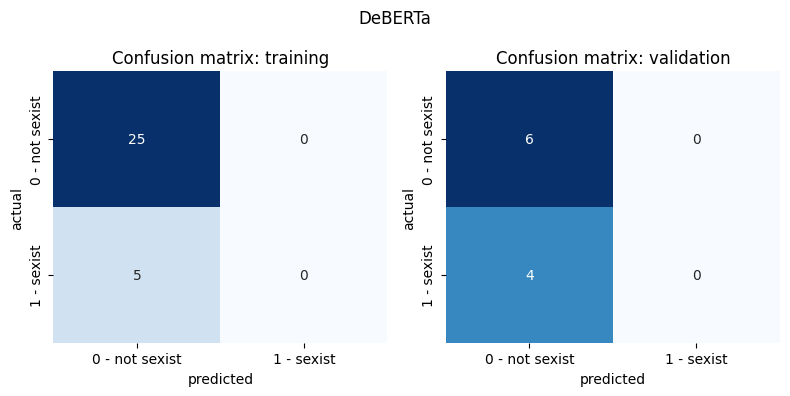

In [5]:
deberta_model = BERTModel("DeBERTa")
deberta_model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

res = deberta_model.evaluate({"training": X_train[:30], "validation": X_val[:10]}, [y_train[:30], y_val[:10]], model_name=deberta_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

#### **3. HateBERT**

Loading pretrained model and tokenizer: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Training started.


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Cross-entropy Loss: 0.5482
Validation Loss: 0.7278, Validation Accuracy: 0.6000
Epoch 2/10, Cross-entropy Loss: 0.4941
Validation Loss: 0.7472, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 0.4162
Validation Loss: 0.7713, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 0.4065
Validation Loss: 0.7977, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


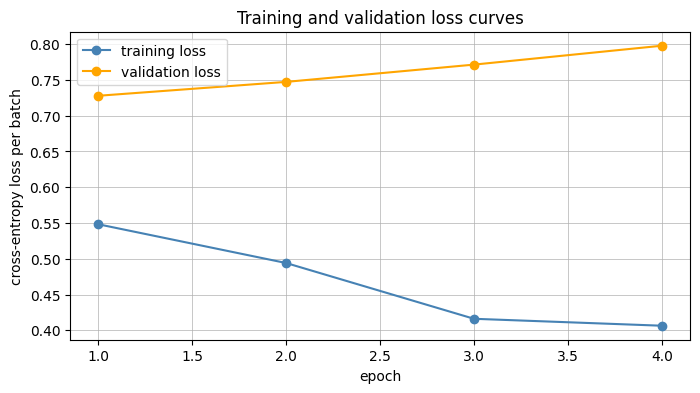

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



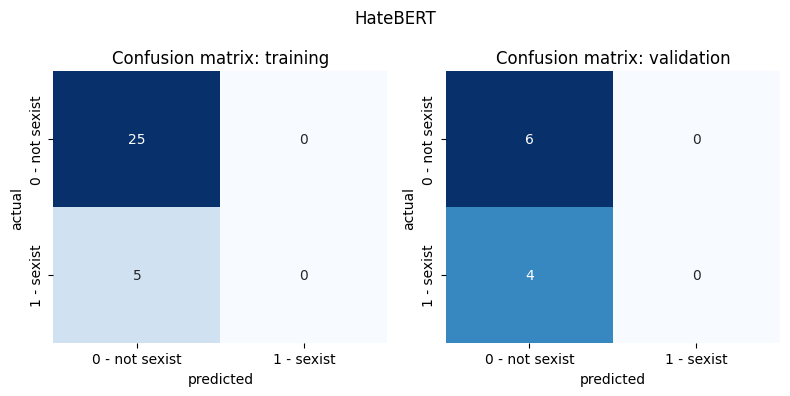

In [6]:
hatebert_model = BERTModel("HateBERT")
hatebert_model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train[:30], "validation": X_val[:10]}, [y_train[:30], y_val[:10]], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

#### **4. DistilBERT**

Loading pretrained model and tokenizer: DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Training started.


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Cross-entropy Loss: 0.6459
Validation Loss: 0.6474, Validation Accuracy: 0.6000
Epoch 2/10, Cross-entropy Loss: 0.5650
Validation Loss: 0.6394, Validation Accuracy: 0.6000
Epoch 3/10, Cross-entropy Loss: 0.5131
Validation Loss: 0.6302, Validation Accuracy: 0.6000
Epoch 4/10, Cross-entropy Loss: 0.4767
Validation Loss: 0.6226, Validation Accuracy: 0.6000
Epoch 5/10, Cross-entropy Loss: 0.4341
Validation Loss: 0.6289, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 6/10, Cross-entropy Loss: 0.3975
Validation Loss: 0.6321, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 7/10, Cross-entropy Loss: 0.3862
Validation Loss: 0.6267, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


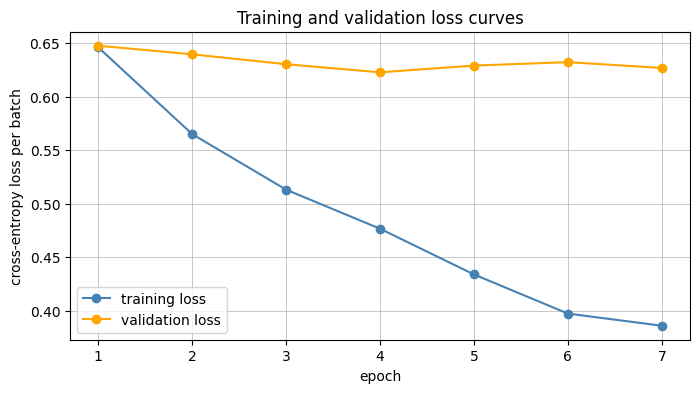

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



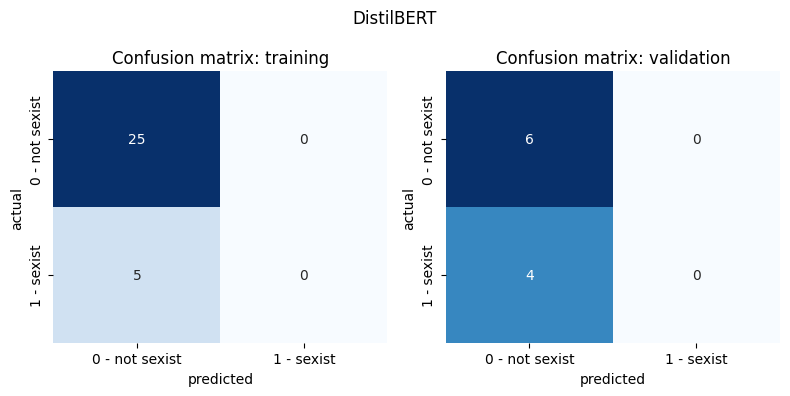

In [7]:
distilbert_model = BERTModel("DistilBERT")
distilbert_model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

res = distilbert_model.evaluate({"training": X_train[:30], "validation": X_val[:10]}, [y_train[:30], y_val[:10]], model_name=distilbert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

### Results

In [8]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,RoBERTa,training,0.833333,0.5,0.0,0.0
1,RoBERTa,validation,0.600000,0.5,0.0,0.0
2,DeBERTa,training,0.833333,0.5,0.0,0.0
3,DeBERTa,validation,0.600000,0.5,0.0,0.0
4,HateBERT,training,0.833333,0.5,0.0,0.0
5,HateBERT,validation,0.600000,0.5,0.0,0.0
6,DistilBERT,training,0.833333,0.5,0.0,0.0
7,DistilBERT,validation,0.600000,0.5,0.0,0.0


# Autoregressive models: LLAMA